<a href="https://colab.research.google.com/github/divyaprabha123/ATOM/blob/master/Cancer_detection_in_Whole_slide_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathological cancer detection of whole slide images

---


> Early detection is important because when abnormal tissue or cancer is found early, it may be easier to treat. By the time symptoms appear, cancer may have begun to spread and be harder to treat. Machine learning can help doctors detecting early signs of cancer and can speed up treatment. 

> This work is about detecting regions of cancer tissues in Whole Slide Images (WSI) using deep learning. 



![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/11848/logos/header.png?t=2018-11-15-01-52-19)

 

> (Image from kaggle.com)


---



### Importing dependencies

In [0]:
import os
from glob import glob
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imgaug import augmenters as iaa
import imgaug as ia

import matplotlib.pyplot as plt
import glob
from PIL import Image
import pandas as pd
import numpy as np


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

## MnasNet: Platform-Aware Neural Architecture Search for Mobile
Kernel reference https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb

![alt text](https://2.bp.blogspot.com/-zFPQEtthyE0/WfuFgDe4VUI/AAAAAAAACIU/4iCF5sNAJuIprvAWnk9uZQK3vTJX5tgcwCLcBGAs/s640/image1.png)

 **MnasNet**: Platform-Aware Neural Architecture Search for Mobile”, An automated neural architecture search approach for designing mobile models using reinforcement learning with added mobile speed constraints for calculating rewards. MnasNet is able to find models that run 1.5x faster than state-of-the-art hand-crafted MobileNetV2 and 2.4x faster than NASNet, while reaching the same ImageNet top 1 accuracy



In [6]:
## Loading the model
inputs = Input((96, 96, 3))
nas_net = NASNetMobile(weights=None, include_top=False, input_shape=(96, 96, 3))
x = nas_net(inputs)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)
model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
batch_size=32
h5_path = "/content/drive/My Drive/model.h5"
model.load_weights(h5_path)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1056)         0           NASNet[1][0]                     
____________________________________________________________________________________________

## Extracting the patches from WSI image
Code Reference 
[Insiyaa https://github.com/Insiyaa/caMicroscope-tfjs-models/](https://github.com/Insiyaa/caMicroscope-tfjs-models/blob/master/Classification%20Sample%20Models/classification-of-HnE-stained-histological-breast-cancer-images/BACH.ipynb)

In [0]:
# Credits: ICIAR2018 by ImagingLabs
class PatchExtractor:
    def __init__(self, img, patch_size, stride):
        '''
        :param img: :py:class:`~PIL.Image.Image`
        :param patch_size: integer, size of the patch
        :param stride: integer, size of the stride
        '''
        self.img = img
        self.size = patch_size
        self.stride = stride

    def extract_patches(self):
        """
        extracts all patches from an image
        :returns: A list of :py:class:`~PIL.Image.Image` objects.
        """
        wp, hp = self.shape()
        return [self.extract_patch((w, h)) for h in range(hp) for w in range(wp)]

    def extract_patch(self, patch):
        """
        extracts a patch from an input image
        :param patch: a tuple
        :rtype: :py:class:`~PIL.Image.Image`
        :returns: An :py:class:`~PIL.Image.Image` object.
        """
        left = patch[0] * self.stride
        up = patch[1] * self.stride
        right = patch[0] * self.stride + self.size
        down = patch[1] * self.stride + self.size
        return self.img.crop((
            left,
            up,
            right,
            down
        )), [left, up, right, down]


    def shape(self):
        wp = int((self.img.width - self.size) / self.stride + 1)
        hp = int((self.img.height - self.size) / self.stride + 1)
        return wp, hp

## Save the extracted patches and the bounding boxes in a dataframe 

In [0]:
img = Image.open("/content/drive/My Drive/CMU-1-Small-Region.svs.tiff")
extractor = PatchExtractor(img=img, patch_size=512, stride=256)
patches = extractor.extract_patches()


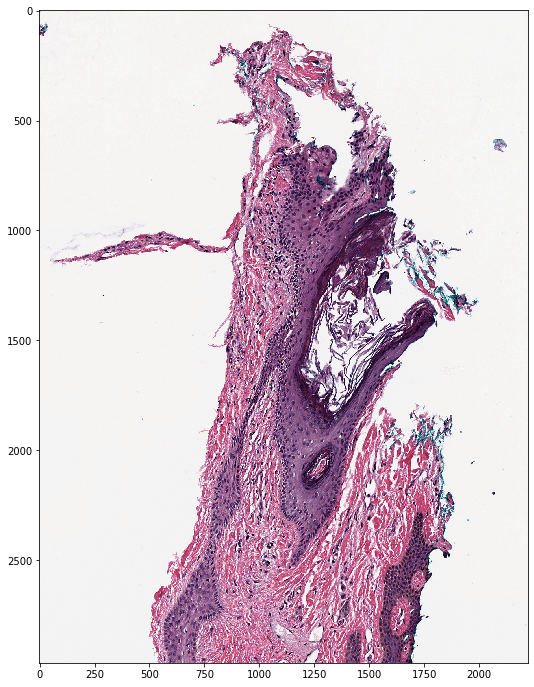

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(img)

In [0]:
#save the patches in a dataframe
data = pd.DataFrame(patches, columns=["Patches","Bounding box"])

In [13]:
data

,Patches,Bounding box
0,<PIL.Image.Image image mode=RGB size=512x512 a...,"[0, 0, 512, 512]"
1,<PIL.Image.Image image mode=RGB size=512x512 a...,"[256, 0, 768, 512]"
2,<PIL.Image.Image image mode=RGB size=512x512 a...,"[512, 0, 1024, 512]"
3,<PIL.Image.Image image mode=RGB size=512x512 a...,"[768, 0, 1280, 512]"
4,<PIL.Image.Image image mode=RGB size=512x512 a...,"[1024, 0, 1536, 512]"
...,...,...
65,<PIL.Image.Image image mode=RGB size=512x512 a...,"[512, 2304, 1024, 2816]"
66,<PIL.Image.Image image mode=RGB size=512x512 a...,"[768, 2304, 1280, 2816]"
67,<PIL.Image.Image image mode=RGB size=512x512 a...,"[1024, 2304, 1536, 2816]"
68,<PIL.Image.Image image mode=RGB size=512x512 a...,"[1280, 2304, 1792, 2816]"


In [0]:
#Covert all the images into numpy array using list comprehension
X = [preprocess_input(np.array(image.resize((96,96)))) for image in data["Patches"]]


### Predictions on each patches

In [0]:
ids_batch = [0]
X = np.array(X)
preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
data["Predictions"] = preds_batch

In [16]:
data

,Patches,Bounding box,Predictions
0,<PIL.Image.Image image mode=RGB size=512x512 a...,"[0, 0, 512, 512]",0.007934
1,<PIL.Image.Image image mode=RGB size=512x512 a...,"[256, 0, 768, 512]",0.107656
2,<PIL.Image.Image image mode=RGB size=512x512 a...,"[512, 0, 1024, 512]",0.000000
3,<PIL.Image.Image image mode=RGB size=512x512 a...,"[768, 0, 1280, 512]",0.148538
4,<PIL.Image.Image image mode=RGB size=512x512 a...,"[1024, 0, 1536, 512]",0.005084
...,...,...,...
65,<PIL.Image.Image image mode=RGB size=512x512 a...,"[512, 2304, 1024, 2816]",0.675041
66,<PIL.Image.Image image mode=RGB size=512x512 a...,"[768, 2304, 1280, 2816]",0.708734
67,<PIL.Image.Image image mode=RGB size=512x512 a...,"[1024, 2304, 1536, 2816]",0.782419
68,<PIL.Image.Image image mode=RGB size=512x512 a...,"[1280, 2304, 1792, 2816]",0.133949


## Simple interactive tool using ipywidgets

In [0]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [20]:
@interact(Threshold=(0.0,1.0,0.1), color="red")
def display(Threshold=0.5):
  img_temp = np.array(img).copy()
  select = data[data["Predictions"]>Threshold]
  select.apply(lambda c: cv2.rectangle(img_temp, (c["Bounding box"][0], c["Bounding box"][1]),\
                                       (c["Bounding box"][2], c["Bounding box"][3]),\
                                       (255,255,0),10), axis=1)

  plt.figure(figsize=(10,10))
  plt.imshow(img_temp)

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0), Output()), _dom_classes=('widg…